<a href="https://colab.research.google.com/github/GitHub-Bong/Toxic-Comment-Challenge/blob/master/0330_LSTM_wt_simpleEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
[For Beginners Tackling Toxic Using Keras](https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# **Data Preprocessing**

03/30 check for nulls

In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/train.csv/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/test.csv/test.csv')

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**check for nulls**

In [ ]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values # y.shape (159571, 6)
list_sentences_train = train["comment_text"] # (159571,)
list_sentences_test = test["comment_text"] # (153164,)

# Tokenization 
 sentence into unique words     
 ex) "I love cats and love dogs" -> ["I","love","cats","and","dogs"]


# **Indexing**
put the words in a dictionary-like structure and give them an index each     
ex) {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}

# **Index Representation**
represent the sequence of words in the comments in the form of index     
ex) ["I","love","cats","and","dogs"] -> [1,2,3,4,5]

In Keras, all the above steps can be done in 4 lines of code     
we have to *define the number of unique words* in our dictionary when tokenizing the sentences

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }

In [ ]:
len(tokenizer.word_index)

210337

**We may have a problem**     
ex)        
Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]      
Comment #2: [1,2]      
<br/>        

we have to feed a stream of data that has a __consistent length(fixed number of features)__       
<br/>
<br/>
     
## We have to use "padding"



In [ ]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (159571, 200)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 200)

Let the max length to be 200
<br/>
<br/>

__If we put it too short,__     
we might lose some useful feature that could cost some accuracy points down 
<br/>
<br/>

__If we put it too long,__     
LSTM cell will have to be larger to store the possible values

One of the ways to go about it is 
<br/>
to __see the distribution of the number of words in sentences__

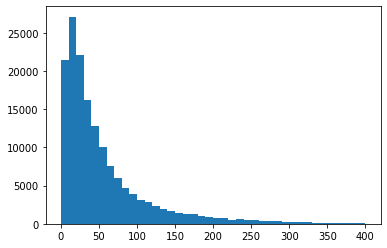

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

------------

# Model 

# Sample structure
![image](https://i.imgur.com/txJomEa.png)


# Input
![image](https://i.imgur.com/uSjU4J7.png)

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=200

**Pass it to Embedding layer**

In [ ]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp) # max_features = 20000

**Output of Embedding layer is <br/> 3-D tensor of (None, 200, 128)**

<br/>= array of sentence
<br/>
For each words(200), there is an array of 128 coordinates 

**Feed this Tensor into the LSTM layer**

# LSTM Layer     
LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]     
->     
3-D tensor of (None, 200, 128) into the LSTM layer     
->      
Recursively run the LSTM model for 200 times      
<br/>
<br/>
Want it to return the whole unrolled sequence of results      

->     
![image](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)
The unrolled LSTM would give us a set of h0,h1,h2 until the last h

In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
# Will receive a Tensor (None, 200, 60) , because we want the unrolled version

# MaxPooling
We need to reshape the 3D tensor into a 2D one     
->     
Use a __Global Max Pooling layer__      
which is traditionally used in CNN problems to reduce the dimensionality of image data

In [ ]:
x = GlobalMaxPool1D()(x)

# Dropout Layer
Pass it to a __Dropout layer__ 

In [ ]:
x = Dropout(0.1)(x)

# Dense Layer
Connect the output of drop out layer to a __densely connected layer__      
and make them passes through a __RELU function__

In [ ]:
x = Dense(50, activation="relu")(x)

# Dropout Layer
Feed the output into a Dropout layer again

In [ ]:
x = Dropout(0.1)(x)

# Dense Layer
Finally, feed the output into a __Sigmoid layer__     
Reason      
we are trying to achieve a __binary classification__  for each of the 6 labels

In [ ]:
x = Dense(6, activation="sigmoid")(x)

## Define the inputs, outputs and configure the learning process <br/><br/> Set Adam optimizer to optimize loss function <br/><br/> Set binary_crossentropy to be a loss function 

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

## A list of 32 padded, indexed sentence for each batch<br/><br/>Split 10% of the data as a validation set

In [ ]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 775s 172ms/step - loss: 0.1179 - accuracy: 0.8477 - val_loss: 0.0493 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 787s 175ms/step - loss: 0.0458 - accuracy: 0.9894 - val_loss: 0.0467 - val_accuracy: 0.9932


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [ ]:
model.predict(X_te[:1])

array([[0.9931177 , 0.5266132 , 0.939724  , 0.26442528, 0.8609197 ,
        0.4475056 ]], dtype=float32)

# Tips
Check if the outputs are performing as expected

In [ ]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape
#print layer_output to see the actual data

(1, 200, 60)

# TODO


*   Using Pre-trained models to boost accuracy and take advantage of existing efforts
*   Hyper-parameter Tuning 


*   Early stopping during training
*   Experiment with different architecture




